## DNA classification
E. coli promoter gene sequences (DNA) with associated imperfect domain theory. Data from UCI repositary

 
- Number of Instances: 106

- Number of Attributes: 59
   - class (positive or negative)
   - instance name
   - 57 sequential nucleotide ("base-pair") positions
- Class Distribution: 50% (53 positive instances, 53 negative instances)


In [1]:
#Check Python Version
import sys
import scipy
import numpy
import matplotlib
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from sklearn import model_selection
import warnings; warnings.simplefilter('ignore')
print('Python: {}'.format(sys.version))


Python: 3.6.7 | packaged by conda-forge | (default, Nov 21 2018, 02:32:25) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [2]:
df0 = pd.read_csv('promoters.data', sep=',', header=None)
df0.columns=['Class', 'id', 'Seq']
df0.head(1)
#df.describe()

,Class,id,Seq
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...


### Preprocessing the Dataset

In [3]:
#in order to train algorithms, we need to clean up data
#make a series for each column.

classes = df0.loc[:, 'Class']
print(classes[:5])

0    +
1    +
2    +
3    +
4    +
Name: Class, dtype: object


In [4]:
# generate list of DNA sequences
sequences = list(df0.loc[:, 'Seq'])
data = {} #build a dictionary

# loop through sequences and split into individual nucleotides
#there are 106 instances
for i, s in enumerate(sequences):
    
    # split into nucleotides, remove tab characters
    nucleotides = list(s)
    nucleotides = [x for x in nucleotides if x != '\t']
    
    # append class assignment
    nucleotides.append(classes[i]) #append classes to the end
    
    # add to dataset
    data[i] = nucleotides
 

print(data[105])


['t', 'a', 'a', 'c', 'a', 't', 't', 'a', 'a', 't', 'a', 'a', 'a', 't', 'a', 'a', 'g', 'g', 'a', 'g', 'g', 'c', 't', 'c', 't', 'a', 'a', 't', 'g', 'g', 'c', 'a', 'c', 't', 'c', 'a', 't', 't', 'a', 'g', 'c', 'c', 'a', 'a', 't', 'c', 'a', 'a', 't', 'c', 'a', 'a', 'g', 'a', 'a', 'c', 't', '-']


In [5]:
# turn dataset into pandas DataFrame
df = pd.DataFrame(data)
df.head

<bound method NDFrame.head of    0   1   2   3   4   5   6   7   8   9   ... 96  97  98  99  100 101 102  \
0    t   t   g   a   t   a   c   t   c   t ...   c   c   t   a   g   c   g   
1    a   g   t   a   c   g   a   t   g   t ...   c   g   a   g   a   c   t   
2    c   c   a   t   g   g   g   t   a   t ...   g   c   t   a   g   t   a   
3    t   t   c   t   a   g   g   c   c   t ...   a   t   g   g   a   c   t   
4    a   a   t   g   t   g   g   t   t   a ...   g   a   a   g   g   a   t   
5    g   t   a   t   a   c   g   a   t   a ...   t   g   c   g   c   a   c   
6    c   c   g   g   a   a   g   c   a   a ...   a   g   c   t   a   t   t   
7    a   c   a   a   t   a   t   a   a   t ...   g   a   g   g   t   g   c   
8    a   t   g   t   t   g   g   a   t   t ...   a   c   a   t   g   g   a   
9    t   g   a   g   a   g   g   a   a   t ...   c   t   a   a   t   c   a   
10   a   a   a   t   a   a   a   a   t   c ...   c   t   c   c   c   c   c   
11   c   c   c   g   c   g   g   c

In [6]:
# transform df
dft = df.transpose()
dft.head(1)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,t,a,c,t,a,g,c,a,a,t,...,g,c,t,t,g,t,c,g,t,+


In [7]:
# rename column 57
dft.rename(columns = {57: 'Class'}, inplace = True) 
dft.head(1)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Class
0,t,a,c,t,a,g,c,a,a,t,...,g,c,t,t,g,t,c,g,t,+


In [8]:
dft.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Class
count,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
unique,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,2
top,t,a,a,c,a,a,a,a,a,a,...,c,c,c,t,t,c,c,c,t,-
freq,38,34,30,30,36,42,38,34,33,36,...,36,42,31,33,35,32,29,29,34,53


In [9]:
# since the attributes are text, let us use value counts to get the frequency of t,c,a,g
# 
series = []
for name in dft.columns:
    series.append(dft[name].value_counts())
    
info_df = pd.DataFrame(series)
info_dft = info_df.transpose()
info_dft

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Class
t,38.0,26.0,27.0,26.0,22.0,24.0,30.0,32.0,32.0,28.0,...,21.0,22.0,23.0,33.0,35.0,30.0,23.0,29.0,34.0,NaN
c,27.0,22.0,21.0,30.0,19.0,18.0,21.0,20.0,22.0,22.0,...,36.0,42.0,31.0,32.0,21.0,32.0,29.0,29.0,17.0,NaN
a,26.0,34.0,30.0,22.0,36.0,42.0,38.0,34.0,33.0,36.0,...,23.0,24.0,28.0,27.0,25.0,22.0,26.0,24.0,27.0,NaN
g,15.0,24.0,28.0,28.0,29.0,22.0,17.0,20.0,19.0,20.0,...,26.0,18.0,24.0,14.0,25.0,22.0,28.0,24.0,28.0,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0
+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0


In [10]:
#convert strings to numeric values using pd.get_dummies
dfn = pd.get_dummies(dft)
dfn.head(5)

,0_a,0_c,0_g,0_t,1_a,1_c,1_g,1_t,2_a,2_c,...,55_a,55_c,55_g,55_t,56_a,56_c,56_g,56_t,Class_+,Class_-
0,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
1,0,0,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0


In [11]:
#since only two classes, drop one
dfn = dfn.drop(columns=['Class_-'])
dfn.rename(columns = {'Class_+': 'Class'}, inplace = True)
dfn.head(5)

,0_a,0_c,0_g,0_t,1_a,1_c,1_g,1_t,2_a,2_c,...,54_t,55_a,55_c,55_g,55_t,56_a,56_c,56_g,56_t,Class
0,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
1,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,0,0,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1


In [12]:
# Create X and Y datasets for training
X = np.array(dfn.drop(['Class'], 1))
y = np.array(dfn['Class'])
seed = 42

# split data into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=seed)

###  Test out some algorithms


In [13]:
# define scoring method
scoring = 'accuracy'


KNN_params = {'n_neighbors':[3]}
GPC_params = {}
DTC_params = {'max_depth':[5]}
RF_params  = {'max_depth':[5], 'n_estimators':[10], 'max_features':[1]}
MLP_params = {'alpha':[0.001],'solver':['adam']}
ADB_params = {}
GaussianNB_params={}
SVCl_params={'kernel':['linear'],'C':[0.01]}
SVCrbf_params={'kernel':['rbf']}
SVCsig_params={'kernel':['sigmoid']}


# Append list of models with parameter dictionaries

models_opt = [] #model with options

models_opt.append(('KNN', KNeighborsClassifier(),KNN_params))
models_opt.append(('GPC', GaussianProcessClassifier(),GPC_params))
models_opt.append(('DTC', DecisionTreeClassifier(), DTC_params))
models_opt.append(('RFC', RandomForestClassifier(), RF_params))
models_opt.append(('MLP', MLPClassifier(), MLP_params))
models_opt.append(('ADB', AdaBoostClassifier(), ADB_params))
models_opt.append(('GNB', GaussianNB(), GaussianNB_params))
models_opt.append(('SVCl', SVC(), SVCl_params))
models_opt.append(('SVCrbf', SVC(), SVCrbf_params))
models_opt.append(('SVCsig', SVC(), SVCsig_params))




In [14]:
results=[]
names=[]

def evaluateModels(param_dict, scoring = 'accuracy'):
    for name, model, params in param_dict:
         
        kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
        model_grid = model_selection.GridSearchCV(model, params)
        cv_results = model_selection.cross_val_score(model_grid, X_train, y_train, cv = kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "Cross Validation %s: Accuracy on training set: %f SD: %f" % (name, cv_results.mean(), cv_results.std())

        print(msg)    
   

In [15]:
#Model evaluation
results=[]
names=[]
evaluateModels(models_opt,scoring='accuracy')

Cross Validation KNN: Accuracy on training set: 0.835714 SD: 0.112031
Cross Validation GPC: Accuracy on training set: 0.837500 SD: 0.158607
Cross Validation DTC: Accuracy on training set: 0.733929 SD: 0.189227
Cross Validation RFC: Accuracy on training set: 0.592857 SD: 0.204665
Cross Validation MLP: Accuracy on training set: 0.860714 SD: 0.103756
Cross Validation ADB: Accuracy on training set: 0.858929 SD: 0.108165
Cross Validation GNB: Accuracy on training set: 0.873214 SD: 0.079238
Cross Validation SVCl: Accuracy on training set: 0.898214 SD: 0.094170
Cross Validation SVCrbf: Accuracy on training set: 0.850000 SD: 0.122474
Cross Validation SVCsig: Accuracy on training set: 0.519643 SD: 0.153499


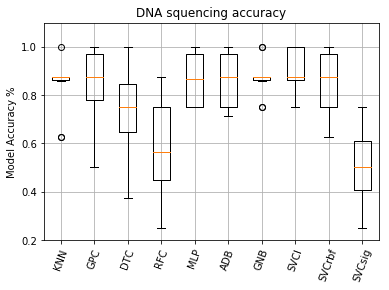

In [16]:
# Visualize model accuracies for comparision - boxplots will be appropriate to visualize 
# data variation

plt.boxplot(results, labels = names)
plt.title('DNA squencing accuracy' )
plt.ylabel('Model Accuracy %')
plt.xticks(rotation=70)
plt.grid()
plt.ylim(0.2,1.1)
plt.show()

In [17]:
#Make predictions on test data set
results_testdata=[]
names=[]
def makePredictions(param_dict):
    for name, model, params in param_dict:
# Make predictions  on validation dataset
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print("===================================================")
        print(name)
        test_acc=accuracy_score(y_test, predictions)
        results_testdata.append(test_acc)
        names.append(name)
        print(test_acc)
        print(classification_report(y_test, predictions))
        

In [18]:
results_testdata=[]
names=[]
makePredictions(models_opt)

KNN
0.7037037037037037
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.68      0.87      0.76        15

   micro avg       0.70      0.70      0.70        27
   macro avg       0.72      0.68      0.68        27
weighted avg       0.71      0.70      0.69        27

GPC
0.8148148148148148
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.75      1.00      0.86        15

   micro avg       0.81      0.81      0.81        27
   macro avg       0.88      0.79      0.80        27
weighted avg       0.86      0.81      0.80        27

DTC
0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.71      1.00      0.83        15

   micro avg       0.78      0.78      0.78        27
   macro avg       0.86      0.75      0.75        27
weigh